# Convolutional Neural Network vs Neural Network vs Support Vector Machine
## Description
1. load the data into  memory
1. peices and labels are in forsyth-edwards notation
    1. this requires us to split the label into the rows of pieces 
    1. this requires us to split the rows of peices into cells
1. images must be transformed into their individual cells
1. use split_test_train to create a test set and train set
1. flatten the images before using as input *(numpy_array_instance.flatten)*

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn import svm
from sklearn.model_selection import learning_curve

import numpy as np
import random


from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder

### Paramaters

In [2]:
path_test = "../input/chess-positions/test/"
path_train = "../input/chess-positions/train/"
batch_size = 100

### Preprocessing Methods

In [3]:
def RandomBatchLoader(directory, batch_size):
    #get files
    files = [directory+f for f in listdir(directory) if isfile(join(directory,f))]
    
    #randomize files
    random.shuffle(files)
    
    #return batch_size subset of random files
    return files[0:batch_size]

def ParseBatch(directory, batch):
    imgs = [mpimg.imread(batch[x]) for x in range(0,len(batch))]
    labels = [batch[x][len(directory):-5] for x in range(0,len(batch))]
    return imgs, labels

def SplitImages(imgs):
    imgs_split = [[img[a:a+50, b:b+50] for a in range(0,400,50) for b in range(0,400,50)] for img in imgs]
    return imgs_split

def SplitFEN(FENS):
    result = []
    for x in range(0,len(FENS)):
        result += SplitFEN_Helper(FENS[x])
    return result

def SplitFEN_Helper(FEN):
    FEN = FEN.replace('-','')
    FEN = list(FEN)
    result = []
    for x in range(0,len(FEN)):
        if FEN[x].isdigit():
            for x in range(0,int(FEN[x])):
                result.append("x")
        else:
            result.append(FEN[x])
    return result

def Preprocess(train_directory, test_directory, train_batch_size, test_batch_size):
    data_train = RandomBatchLoader(train_directory, train_batch_size)
    data_test = RandomBatchLoader(test_directory, test_batch_size)
    
    X_train, y_train = ParseBatch(train_directory, data_train)
    X_test, y_test = ParseBatch(test_directory, data_test)
    
    X_train = SplitImages(X_train)
    y_train = SplitFEN(y_train)
    X_test = SplitImages(X_test)
    y_test = SplitFEN(y_test)
    
    #normalize
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_train = X_train / 255
    X_test = X_test / 255

    X_train = X_train.reshape(64*train_batch_size,50,50,3)
    X_test = X_test.reshape(64*test_batch_size,50,50,3)
    
    #label encode
    label_encoder = LabelEncoder()
    label_encoder.fit(['p','n','b','r','q','k','x', 'P', 'N', 'B', 'R', 'Q', 'K'])
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    return X_train, y_train, X_test, y_test, label_encoder

def PreprocessSingle(X_file, directory, label_encoder):
    X = [mpimg.imread(directory+X_file)]
    y = [X_file[:-5]]
    
    X = SplitImages(X)
    y = SplitFEN(y)
    
    X = np.array(X)
    X = X / 255
    y_encoded = label_encoder.transform(y)
    
    X = X[0]
    
    return X, y_encoded, y

## Fetch Data

In [4]:
X_train, y_train, X_test, y_test, label_encoder = Preprocess(path_train, path_test, batch_size, batch_size)

## Support Vector Machine

In [5]:
def create_train_test_SVM(X_train, y_train, X_test, y_test):
    #svm will look at each of 50*50*3 as a different feature
    X_train = X_train.reshape(64*batch_size, 50*50*3)
    X_test = X_test.reshape(64*batch_size, 50*50*3)
    
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    
    print("Validation Set Accuracy: ",confidence)
    return clf

In [6]:
clf = create_train_test_SVM(X_train,y_train,X_test,y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Validation Set Accuracy:  0.9409375


## Let's evaluate the output of a single input

In [7]:
file = listdir(path_test)[0]
print(file)
X, y_encoded, y = PreprocessSingle(file, path_test, label_encoder)

X = X.reshape(64,50*50*3)
yp = clf.predict(X)

4K2k-5P2-8-2b1P1q1-8-8-8-1q2Bn2.jpeg


In [8]:
print("predicted values (encoded): ")
print(yp)

print("\nactual values (encoded): ")
print(y_encoded)

print("\npredicted values: ")
print(label_encoder.inverse_transform(yp))

print("\nactual values: ")
print(label_encoder.inverse_transform(y_encoded))

predicted values (encoded): 
[12 12 12 12  1 12 12  7 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12  6 12 12 12  7 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12  7 12 12  0  8 12 12]

actual values (encoded): 
[12 12 12 12  1 12 12  7 12 12 12 12 12  3 12 12 12 12 12 12 12 12 12 12
 12 12  6 12  3 12 10 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 10 12 12  0  8 12 12]

predicted values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'k' 'x' 'x' 'B' 'n' 'x' 'x']

actual values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'P' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'P' 'x' 'q' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'q' 'x' 'x' 'B' 'n' 'x

## Support Vectors

In [9]:
clf.support_vectors_

array([[0.75686275, 0.83529412, 0.78823529, ..., 0.83921569, 0.90588235,
        0.86666667],
       [0.85882353, 0.92156863, 0.87843137, ..., 0.80784314, 0.87843137,
        0.83137255],
       [0.31372549, 0.40784314, 0.35294118, ..., 0.35294118, 0.45882353,
        0.4       ],
       ...,
       [0.11372549, 0.09803922, 0.08627451, ..., 0.09803922, 0.08235294,
        0.07058824],
       [0.33333333, 0.31764706, 0.30588235, ..., 0.21568627, 0.2       ,
        0.19607843],
       [0.12941176, 0.11372549, 0.10196078, ..., 0.02745098, 0.02352941,
        0.01568627]])

# Dense Neural Network

In [10]:
def Create_Model_NN():
    model = models.Sequential()
    
    model.add(layers.Dense(5, input_shape=(50,50,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(13, activation='softmax'))
    model.summary()
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

def train_test_model_NN(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    return history

In [11]:
model = Create_Model_NN()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50, 50, 5)         20        
_________________________________________________________________
flatten (Flatten)            (None, 12500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                800064    
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 800,929
Trainable params: 800,929
Non-trainable params: 0
_________________________________________________________________


Train on 6400 samples, validate on 6400 samples
Epoch 1/10
6400/6400 [==============================] - 3s 490us/sample - loss: 0.6969 - accuracy: 0.8458 - val_loss: 0.5359 - val_accuracy: 0.8850
Epoch 2/10
6400/6400 [==============================] - 1s 213us/sample - loss: 0.3392 - accuracy: 0.9114 - val_loss: 0.3324 - val_accuracy: 0.9248
Epoch 3/10
6400/6400 [==============================] - 1s 214us/sample - loss: 0.1769 - accuracy: 0.9555 - val_loss: 0.2068 - val_accuracy: 0.9586
Epoch 4/10
6400/6400 [==============================] - 1s 219us/sample - loss: 0.1105 - accuracy: 0.9727 - val_loss: 0.2073 - val_accuracy: 0.9539
Epoch 5/10
6400/6400 [==============================] - 1s 213us/sample - loss: 0.0768 - accuracy: 0.9816 - val_loss: 0.1213 - val_accuracy: 0.9795
Epoch 6/10
6400/6400 [==============================] - 1s 215us/sample - loss: 0.0410 - accuracy: 0.9897 - val_loss: 0.1500 - val_accuracy: 0.9717
Epoch 7/10
6400/6400 [==============================] - 1s 214us

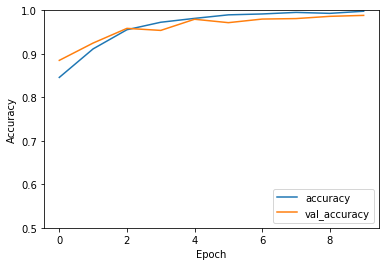

In [12]:
history = train_test_model_NN(model,X_train, y_train, X_test, y_test)


In [13]:
def ClarifyPrediction_NN(yp):
    return [np.where(yp[x] == np.amax(yp[x]))[0][0] for x in range(0,len(yp))]

In [14]:
file = listdir(path_test)[0]
print(file)

4K2k-5P2-8-2b1P1q1-8-8-8-1q2Bn2.jpeg


In [15]:
X, y_encoded, y = PreprocessSingle(file,path_test,label_encoder)

yp = model.predict(X, batch_size=64)
yp = ClarifyPrediction_NN(yp)

In [16]:
print("predicted values (encoded): ")
print(yp)

print("\nactual values (encoded): ")
print(y_encoded)

print("\npredicted values: ")
print(label_encoder.inverse_transform(yp))

print("\nactual values: ")
print(label_encoder.inverse_transform(y_encoded)) 

predicted values (encoded): 
[12, 12, 12, 12, 1, 12, 12, 7, 12, 12, 12, 12, 12, 3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 6, 12, 3, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 0, 8, 12, 12]

actual values (encoded): 
[12 12 12 12  1 12 12  7 12 12 12 12 12  3 12 12 12 12 12 12 12 12 12 12
 12 12  6 12  3 12 10 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 10 12 12  0  8 12 12]

predicted values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'P' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'P' 'x' 'q' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'q' 'x' 'x' 'B' 'n' 'x' 'x']

actual values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'P' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'P' 'x' 'q' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' '

## Weights

In [17]:
model.get_weights()

[array([[ 0.9325643 , -0.14628536,  0.2027733 , -0.72056913, -0.68194014],
        [-0.2608039 , -0.35524786, -0.32310838,  0.07068647,  0.02442701],
        [ 0.29988053, -0.49494162,  0.92205894,  0.5032303 , -0.22689603]],
       dtype=float32),
 array([-0.09711964,  0.        , -0.1572627 ,  0.07089481,  0.28170937],
       dtype=float32),
 array([[ 0.01022118,  0.02267472,  0.00041516, ..., -0.02802962,
         -0.01597771, -0.00882327],
        [ 0.00543697,  0.00815909,  0.00197666, ..., -0.00158655,
         -0.01985318, -0.01753854],
        [-0.03669711,  0.01372011,  0.0382765 , ...,  0.03396044,
          0.0022048 , -0.00154159],
        ...,
        [-0.00764182, -0.01867887,  0.04442768, ...,  0.0352799 ,
          0.00232986,  0.02420799],
        [ 0.02866962,  0.0769696 ,  0.12817384, ...,  0.08574761,
         -0.03389562,  0.06160673],
        [-0.01211997,  0.05638972,  0.08772192, ...,  0.12793161,
         -0.00527643, -0.0753246 ]], dtype=float32),
 array([ 1.1

# Convolutional Neural Network

In [18]:
def Create_Model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50,50, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(13, activation='softmax'))
    model.summary()
    
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

def train_test_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    return history

In [19]:
model = Create_Model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

Train on 6400 samples, validate on 6400 samples
Epoch 1/10
6400/6400 [==============================] - 5s 761us/sample - loss: 0.3722 - accuracy: 0.9016 - val_loss: 0.1072 - val_accuracy: 0.9753
Epoch 2/10
6400/6400 [==============================] - 2s 253us/sample - loss: 0.0500 - accuracy: 0.9847 - val_loss: 0.0515 - val_accuracy: 0.9881
Epoch 3/10
6400/6400 [==============================] - 2s 250us/sample - loss: 0.0265 - accuracy: 0.9937 - val_loss: 0.0488 - val_accuracy: 0.9897
Epoch 4/10
6400/6400 [==============================] - 2s 253us/sample - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0441 - val_accuracy: 0.9889
Epoch 5/10
6400/6400 [==============================] - 2s 250us/sample - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0291 - val_accuracy: 0.9950
Epoch 6/10
6400/6400 [==============================] - 2s 252us/sample - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0639 - val_accuracy: 0.9858
Epoch 7/10
6400/6400 [==============================] - 2s 251us

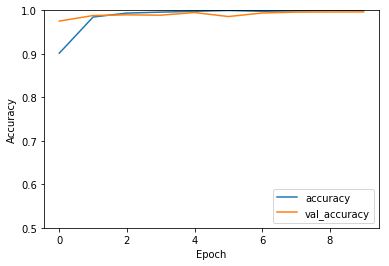

In [20]:
history = train_test_model(model,X_train, y_train, X_test, y_test)


In [21]:
def ClarifyPrediction(yp):
    return [np.where(yp[x] == np.amax(yp[x]))[0][0] for x in range(0,len(yp))]

In [22]:
file = listdir(path_test)[0]
print(file)

4K2k-5P2-8-2b1P1q1-8-8-8-1q2Bn2.jpeg


In [23]:
X, y_encoded, y = PreprocessSingle(file,path_test,label_encoder)

yp = model.predict(X, batch_size=64)
yp = ClarifyPrediction(yp)

In [24]:
print("predicted values (encoded): ")
print(yp)

print("\nactual values (encoded): ")
print(y_encoded)

print("\npredicted values: ")
print(label_encoder.inverse_transform(yp))

print("\nactual values: ")
print(label_encoder.inverse_transform(y_encoded)) 

predicted values (encoded): 
[12, 12, 12, 12, 1, 12, 12, 7, 12, 12, 12, 12, 12, 3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 6, 12, 3, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 0, 8, 12, 12]

actual values (encoded): 
[12 12 12 12  1 12 12  7 12 12 12 12 12  3 12 12 12 12 12 12 12 12 12 12
 12 12  6 12  3 12 10 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 10 12 12  0  8 12 12]

predicted values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'P' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'P' 'x' 'q' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'q' 'x' 'x' 'B' 'n' 'x' 'x']

actual values: 
['x' 'x' 'x' 'x' 'K' 'x' 'x' 'k' 'x' 'x' 'x' 'x' 'x' 'P' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'b' 'x' 'P' 'x' 'q' 'x' 'x' 'x' 'x' 'x'
 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x' '

In [25]:
model.get_weights()

[array([[[[-5.93089648e-02,  1.04293618e-02,  4.44578268e-02,
           -1.73147157e-01, -1.09708160e-01,  8.81044343e-02,
            5.22553064e-02, -1.02514975e-01,  2.02213526e-02,
            3.89566347e-02, -5.54736704e-02, -3.03780921e-02,
           -8.43022242e-02,  4.20883931e-02, -6.57960027e-02,
            8.01964998e-02, -1.70919597e-02, -8.71937722e-02,
            5.78866154e-02, -1.39727771e-01, -7.10417703e-02,
           -6.76558986e-02, -4.78067547e-02, -5.48141301e-02,
           -1.28541604e-01, -2.87042689e-02, -1.29761696e-01,
            5.29889911e-02,  1.10256024e-01,  3.34403366e-02,
            5.58444485e-02, -9.96662676e-02],
          [ 9.01741758e-02, -1.10419482e-01, -8.11030194e-02,
           -3.08035966e-03, -1.42629042e-01, -1.49279147e-01,
           -1.08523056e-01,  3.17151956e-02,  7.93139450e-03,
            2.31692065e-02, -3.91778871e-02,  4.65885438e-02,
           -7.61698931e-02,  6.15705512e-02,  8.33477676e-02,
            1.22479850e-